In [1]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
r = requests.get('http://swapi.dev/api/')

r.json()

{'people': 'https://swapi.dev/api/people/',
 'planets': 'https://swapi.dev/api/planets/',
 'films': 'https://swapi.dev/api/films/',
 'species': 'https://swapi.dev/api/species/',
 'vehicles': 'https://swapi.dev/api/vehicles/',
 'starships': 'https://swapi.dev/api/starships/'}

Get Full Data of a type (people, planets, vehicles...)

In [3]:
def get_full_type_data(base_url):
    data =  requests.get(base_url)
    all_data = []
    data_num = 0
    for i in range(200):
        if data_num < data.json()['count']+1:
            trial=requests.get(base_url+str(i))
            if str(trial) != '<Response [404]>':
                all_data.append(trial.json())
                data_num+=1
    all_data = pd.json_normalize(all_data)
    return all_data

Data Cleaning: Numerical columns

In [4]:
def df_columns_to_numeric(df,columns):
    for column_i in columns:
        unusual_index_list = df.index[df[column_i].str.contains("\D")].tolist()
        # Rule out the unusual charactor in a numeric column
        if len(unusual_index_list)>0:
            df.loc[unusual_index_list,column_i]=np.nan
        df[column_i]=pd.to_numeric(df[column_i])
    return df

PEOPLE

In [6]:
peoples = requests.get('https://swapi.dev/api/people/').json()

In [7]:
print(peoples['count'],"number of people in starwars")

82 number of people in starwars


In [69]:
people = get_full_type_data('https://swapi.dev/api/people/')

In [70]:
#Check number and dimension of data
people.shape

(82, 16)

In [71]:
#show the dataset 
people.head(3)

,name,height,mass,hair_color,skin_color,eye_color,birth_year,gender,homeworld,films,species,vehicles,starships,created,edited,url
0,Luke Skywalker,172,77,blond,fair,blue,19BBY,male,https://swapi.dev/api/planets/1/,"[https://swapi.dev/api/films/1/, https://swapi...",[],"[https://swapi.dev/api/vehicles/14/, https://s...","[https://swapi.dev/api/starships/12/, https://...",2014-12-09T13:50:51.644000Z,2014-12-20T21:17:56.891000Z,https://swapi.dev/api/people/1/
1,C-3PO,167,75,n/a,gold,yellow,112BBY,n/a,https://swapi.dev/api/planets/1/,"[https://swapi.dev/api/films/1/, https://swapi...",[https://swapi.dev/api/species/2/],[],[],2014-12-10T15:10:51.357000Z,2014-12-20T21:17:50.309000Z,https://swapi.dev/api/people/2/
2,R2-D2,96,32,n/a,"white, blue",red,33BBY,n/a,https://swapi.dev/api/planets/8/,"[https://swapi.dev/api/films/1/, https://swapi...",[https://swapi.dev/api/species/2/],[],[],2014-12-10T15:11:50.376000Z,2014-12-20T21:17:50.311000Z,https://swapi.dev/api/people/3/


In [28]:
people.to_csv("people.csv",index=False) # Save data, so do not need to fetch data a second time

In [29]:
#Next time, just run this
# people = pd.read_csv("people.csv")

In [72]:
people.columns

Index(['name', 'height', 'mass', 'hair_color', 'skin_color', 'eye_color',
       'birth_year', 'gender', 'homeworld', 'films', 'species', 'vehicles',
       'starships', 'created', 'edited', 'url'],
      dtype='object')

In [73]:
# Featuring

people['film_num']=people['films'].apply(lambda x:len(x))

people['vehicles_num']=people['vehicles'].apply(lambda x:len(x))

people['starships_num']=people['starships'].apply(lambda x:len(x))

people=people.replace('unknown',np.NaN)

# There some error in the mass
people['mass']=people['mass'].apply(lambda x: str(x).replace(',','.'))

people[['mass','height']]=people[['mass','height']].astype('float')

people['bmi']=people['mass']/(people['height']/100)**2

people.describe()

,height,mass,film_num,vehicles_num,starships_num,bmi
count,81.000000,59.000000,82.000000,82.000000,82.000000,59.000000
mean,174.604938,74.317932,1.975610,0.158537,0.365854,24.483117
std,34.774157,30.566597,1.305029,0.429456,0.839050,7.506952
min,66.000000,1.358000,1.000000,0.000000,0.000000,0.443429
25%,167.000000,55.000000,1.000000,0.000000,0.000000,21.196660
50%,180.000000,79.000000,1.000000,0.000000,0.000000,24.464602
75%,191.000000,84.000000,3.000000,0.000000,0.000000,26.342474
max,264.000000,159.000000,6.000000,2.000000,5.000000,50.928022


In [74]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected stage_dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

In [75]:
missing_values_table(people)

Your selected stage_dataframe has 20 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
birth_year,39,47.6
mass,23,28.0
bmi,23,28.0
eye_color,2,2.4
height,1,1.2
skin_color,1,1.2


Person with max height

In [76]:
h_max_name=people.iloc[people['height'].idxmax()]['name']
h_max_value=people['height'].max()

print(f"The most taller in the sample is {h_max_name} with {h_max_value} cm")

The most taller in the sample is Yarael Poof with 264.0 cm


Person with max mass

In [77]:
mass_max_name=people.iloc[people['mass'].idxmax()]['name']
mass_max_value=people['mass'].max()

print(f"The most weighted in the sample is {mass_max_name} with {mass_max_value} kg")

The most weighted in the sample is Grievous with 159.0 kg


Is there a correlation with height and mass?

<AxesSubplot:>

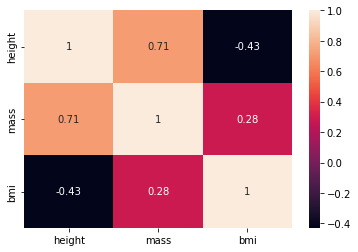

In [78]:
import seaborn as sns

corr=people[['height','mass','bmi']].corr()

sns.heatmap(corr,annot=True)

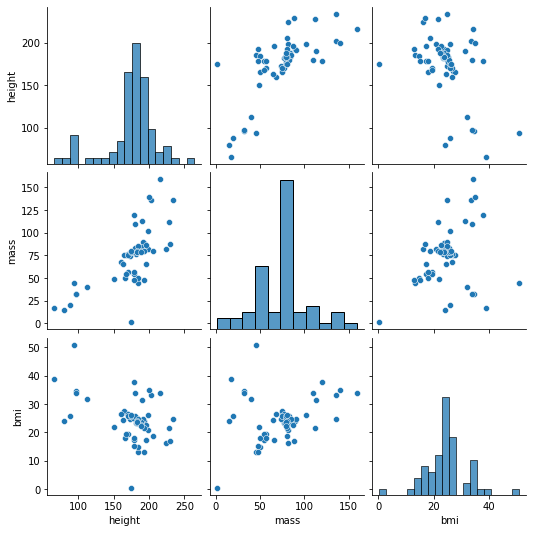

In [79]:
sns.pairplot(people[['height','mass','bmi']])
plt.show()

Looks like some of the people in starwars maybe unhealthy 

the healthy range is 18.5 to 24.9.

In [80]:
def health_type(x):
    if x<18.5:
        return 'too_thin'
    elif x>24.9:
        return 'too_fat'
    else:
        return 'healthy:)'

people['health']=people['bmi'].apply(lambda x: health_type(x))

In [81]:
people['health'].value_counts()

healthy:)    47
too_fat      24
too_thin     11
Name: health, dtype: int64

In [82]:
people.tail(3)

,name,height,mass,hair_color,skin_color,eye_color,birth_year,gender,homeworld,films,...,vehicles,starships,created,edited,url,film_num,vehicles_num,starships_num,bmi,health
79,Raymus Antilles,188.0,79.0,brown,light,brown,NaN,male,https://swapi.dev/api/planets/2/,"[https://swapi.dev/api/films/1/, https://swapi...",...,[],[],2014-12-20T19:49:35.583000Z,2014-12-20T21:17:50.493000Z,https://swapi.dev/api/people/81/,2,0,0,22.351743,healthy:)
80,Sly Moore,178.0,48.0,none,pale,white,NaN,female,https://swapi.dev/api/planets/60/,"[https://swapi.dev/api/films/5/, https://swapi...",...,[],[],2014-12-20T20:18:37.619000Z,2014-12-20T21:17:50.496000Z,https://swapi.dev/api/people/82/,2,0,0,15.149602,too_thin
81,Tion Medon,206.0,80.0,none,grey,black,NaN,male,https://swapi.dev/api/planets/12/,[https://swapi.dev/api/films/6/],...,[],[],2014-12-20T20:35:04.260000Z,2014-12-20T21:17:50.498000Z,https://swapi.dev/api/people/83/,1,0,0,18.851918,healthy:)


In [95]:
people.groupby(['homeworld']).agg({'film_num': ['mean', 'min', 'max','count','size','std','sem','first','last'],'vehicles_num': ['mean', 'min', 'max'],'starships_num': ['mean', 'min', 'max']})

film_num                               \
                                       mean min max count size       std   
homeworld                                                                  
https://swapi.dev/api/planets/1/   2.800000   1   6    10   10  1.619328   
https://swapi.dev/api/planets/10/  1.666667   1   3     3    3  1.154701   
https://swapi.dev/api/planets/11/  2.000000   2   2     1    1       NaN   
https://swapi.dev/api/planets/12/  1.000000   1   1     1    1       NaN   
https://swapi.dev/api/planets/14/  2.500000   1   4     2    2  2.121320   
https://swapi.dev/api/planets/18/  3.000000   3   3     1    1       NaN   
https://swapi.dev/api/planets/2/   2.666667   2   4     3    3  1.154701   
https://swapi.dev/api/planets/20/  6.000000   6   6     1    1       NaN   
https://swapi.dev/api/planets/21/  2.000000   2   2     1    1       NaN   
https://swapi.dev/api/planets/22/  3.000000   3   3     2    2  0.000000   
https://swapi.dev/api/planets/23/  1.000000   1   1     1    1       NaN   
https://swapi.dev/api/planets/24/  3.000000   3   3     1    1       NaN   
https://swapi.dev/api/planets/26/  1.000000   1   1     1    1       NaN   
https://swapi.dev/api/planets/28/  2.000000   1   5     5    5  1.732051   
https://swapi.dev/api/planets/29/  1.000000   1   1     1    1       NaN   
https://swapi.dev/api/planets/30/  2.000000   2   2     1    1       NaN   
https://swapi.dev/api/planets/31/  1.000000   1   1     1    1       NaN   
https://swapi.dev/api/planets/32/  1.000000   1   1     1    1       NaN   
https://swapi.dev/api/planets/33/  1.000000   1   1     1    1       NaN   
https://swapi.dev/api/planets/34/  2.000000   2   2     1    1       NaN   
https://swapi.dev/api/planets/35/  1.000000   1   1     1    1       NaN   
https://swapi.dev/api/planets/36/  1.000000   1   1     1    1       NaN   
https://swapi.dev/api/planets/37/  2.000000   1   3     2    2  1.414214   
https://swapi.dev/api/planets/38/  1.000000   1   1     1    1       NaN   
https://swapi.dev/api/planets/39/  1.000000   1   1     1    1       NaN   
https://swapi.dev/api/planets/40/  1.000000   1   1     1    1       NaN   
https://swapi.dev/api/planets/41/  1.000000   1   1     1    1       NaN   
https://swapi.dev/api/planets/42/  3.000000   3   3     1    1       NaN   
https://swapi.dev/api/planets/43/  3.000000   3   3     1    1       NaN   
https://swapi.dev/api/planets/44/  3.000000   3   3     1    1       NaN   
https://swapi.dev/api/planets/45/  2.000000   2   2     1    1       NaN   
https://swapi.dev/api/planets/47/  2.000000   2   2     1    1       NaN   
https://swapi.dev/api/planets/48/  1.000000   1   1     1    1       NaN   
https://swapi.dev/api/planets/49/  3.000000   3   3     1    1       NaN   
https://swapi.dev/api/planets/50/  2.000000   2   2     1    1       NaN   
https://swapi.dev/api/planets/51/  1.500000   1   2     2    2  0.707107   
https://swapi.dev/api/planets/52/  2.000000   2   2     1    1       NaN   
https://swapi.dev/api/planets/53/  1.000000   1   1     1    1       NaN   
https://swapi.dev/api/planets/54/  1.000000   1   1     1    1       NaN   
https://swapi.dev/api/planets/55/  1.000000   1   1     1    1       NaN   
https://swapi.dev/api/planets/56/  1.000000   1   1     1    1       NaN   
https://swapi.dev/api/planets/57/  1.000000   1   1     1    1       NaN   
https://swapi.dev/api/planets/58/  2.000000   2   2     1    1       NaN   
https://swapi.dev/api/planets/59/  1.000000   1   1     1    1       NaN   
https://swapi.dev/api/planets/6/   1.000000   1   1     1    1       NaN   
https://swapi.dev/api/planets/60/  2.000000   2   2     1    1       NaN   
https://swapi.dev/api/planets/7/   1.000000   1   1     1    1       NaN   
https://swapi.dev/api/planets/8/   2.090909   1   6    11   11  1.814086   
https://swapi.dev/api/planets/9/   1.333333   1   2     3    3  0.577350   

                                                       vehicles_num          \
   

# Characters by gender

In [83]:
people[['name','gender']].groupby(["gender"]).count()

,name
gender,
female,17
hermaphrodite,1
male,60
n/a,3
none,1


Most of characters are male followed by women and hermaphrodite are very rare with just one person. There is none character that we didn't his gender

According to BBY-ABY system: https://starwars.fandom.com/wiki/%27ABY-BBY%27_dating_system

Let's compare who is older

In [94]:
# Transform BBY-ABY datetime system to numeric. 
# negative number means before the Battle of Yavin, positive number means aferthe Battle of Yavin
def abby_to_num(x):
    if type(x) == float:
        return x
    else:
        if x == 'unknown':
            return np.nan
        elif x[-3:] == 'BBY':
            return -float(x[:-3])
        elif x[-3:] == 'ABY':
            return float(x[:-3])
        else:
            print(x)
            print("Something wrong!")

people['birth_date_num'] = people['birth_year'].apply(lambda x: abby_to_num(x))
    
people.head(3)

,name,height,mass,hair_color,skin_color,eye_color,birth_year,gender,homeworld,films,...,starships,created,edited,url,film_num,vehicles_num,starships_num,bmi,health,birth_date_num
0,Luke Skywalker,172.0,77.0,blond,fair,blue,19BBY,male,https://swapi.dev/api/planets/1/,"[https://swapi.dev/api/films/1/, https://swapi...",...,"[https://swapi.dev/api/starships/12/, https://...",2014-12-09T13:50:51.644000Z,2014-12-20T21:17:56.891000Z,https://swapi.dev/api/people/1/,4,2,2,26.027582,too_fat,-19.0
1,C-3PO,167.0,75.0,n/a,gold,yellow,112BBY,n/a,https://swapi.dev/api/planets/1/,"[https://swapi.dev/api/films/1/, https://swapi...",...,[],2014-12-10T15:10:51.357000Z,2014-12-20T21:17:50.309000Z,https://swapi.dev/api/people/2/,6,0,0,26.892323,too_fat,-112.0
2,R2-D2,96.0,32.0,n/a,"white, blue",red,33BBY,n/a,https://swapi.dev/api/planets/8/,"[https://swapi.dev/api/films/1/, https://swapi...",...,[],2014-12-10T15:11:50.376000Z,2014-12-20T21:17:50.311000Z,https://swapi.dev/api/people/3/,6,0,0,34.722222,too_fat,-33.0


In [93]:
people[['name','birth_year','birth_date_num']].sort_values(by=['birth_date_num'],ascending=True)

,name,birth_year,birth_date_num
18,Yoda,896BBY,-896.0
15,Jabba Desilijic Tiure,600BBY,-600.0
12,Chewbacca,200BBY,-200.0
1,C-3PO,112BBY,-112.0
65,Dooku,102BBY,-102.0
...,...,...,...
77,Grievous,NaN,NaN
78,Tarfful,NaN,NaN
79,Raymus Antilles,NaN,NaN
80,Sly Moore,NaN,NaN


YODA is the oldest creature.

PLANETS

In [108]:
planets = requests.get('http://swapi.dev/api/planets')

planets.json()

{'count': 60,
 'next': 'https://swapi.dev/api/planets/?page=2',
 'previous': None,
 'results': [{'name': 'Tatooine',
   'rotation_period': '23',
   'orbital_period': '304',
   'diameter': '10465',
   'climate': 'arid',
   'gravity': '1 standard',
   'terrain': 'desert',
   'surface_water': '1',
   'population': '200000',
   'residents': ['https://swapi.dev/api/people/1/',
    'https://swapi.dev/api/people/2/',
    'https://swapi.dev/api/people/4/',
    'https://swapi.dev/api/people/6/',
    'https://swapi.dev/api/people/7/',
    'https://swapi.dev/api/people/8/',
    'https://swapi.dev/api/people/9/',
    'https://swapi.dev/api/people/11/',
    'https://swapi.dev/api/people/43/',
    'https://swapi.dev/api/people/62/'],
   'films': ['https://swapi.dev/api/films/1/',
    'https://swapi.dev/api/films/3/',
    'https://swapi.dev/api/films/4/',
    'https://swapi.dev/api/films/5/',
    'https://swapi.dev/api/films/6/'],
   'created': '2014-12-09T13:50:49.641000Z',
   'edited': '2014-12-20T

In [22]:
planets_df = get_full_type_data('http://swapi.dev/api/planets/')
print("Number of planets",planets_df.shape[0])

Number of planets 60


In [23]:
planets_df.to_csv("planets.csv",index=False) # Save data, so do not need to fetch data a second time

In [124]:
#Next time, just run this
planets_df = pd.read_csv("planets.csv")
planets_df.head(3)

,name,rotation_period,orbital_period,diameter,climate,gravity,terrain,surface_water,population,residents,films,created,edited,url
0,Tatooine,23,304,10465,arid,1 standard,desert,1,200000,"['https://swapi.dev/api/people/1/', 'https://s...","['https://swapi.dev/api/films/1/', 'https://sw...",2014-12-09T13:50:49.641000Z,2014-12-20T20:58:18.411000Z,https://swapi.dev/api/planets/1/
1,Alderaan,24,364,12500,temperate,1 standard,"grasslands, mountains",40,2000000000,"['https://swapi.dev/api/people/5/', 'https://s...","['https://swapi.dev/api/films/1/', 'https://sw...",2014-12-10T11:35:48.479000Z,2014-12-20T20:58:18.420000Z,https://swapi.dev/api/planets/2/
2,Yavin IV,24,4818,10200,"temperate, tropical",1 standard,"jungle, rainforests",8,1000,[],['https://swapi.dev/api/films/1/'],2014-12-10T11:37:19.144000Z,2014-12-20T20:58:18.421000Z,https://swapi.dev/api/planets/3/


In [24]:
planet_numeric_cols=['rotation_period','orbital_period','diameter','surface_water','population']

planets_df=planets_df.replace('unknown',np.NaN)

planets_df[planet_numeric_cols] = planets_df[planet_numeric_cols].astype('float')

In [25]:
missing_values_table(planets_df)

Your selected stage_dataframe has 14 columns.
There are 9 columns that have missing values.


,Missing Values,% of Total Values
surface_water,34,56.7
population,17,28.3
diameter,16,26.7
gravity,15,25.0
rotation_period,12,20.0
orbital_period,12,20.0
climate,12,20.0
terrain,7,11.7
name,1,1.7


In [26]:
planets_df.head(3)

,name,rotation_period,orbital_period,diameter,climate,gravity,terrain,surface_water,population,residents,films,created,edited,url
0,Tatooine,23.0,304.0,10465.0,arid,1 standard,desert,1.0,2.000000e+05,"[https://swapi.dev/api/people/1/, https://swap...","[https://swapi.dev/api/films/1/, https://swapi...",2014-12-09T13:50:49.641000Z,2014-12-20T20:58:18.411000Z,https://swapi.dev/api/planets/1/
1,Alderaan,24.0,364.0,12500.0,temperate,1 standard,"grasslands, mountains",40.0,2.000000e+09,"[https://swapi.dev/api/people/5/, https://swap...","[https://swapi.dev/api/films/1/, https://swapi...",2014-12-10T11:35:48.479000Z,2014-12-20T20:58:18.420000Z,https://swapi.dev/api/planets/2/
2,Yavin IV,24.0,4818.0,10200.0,"temperate, tropical",1 standard,"jungle, rainforests",8.0,1.000000e+03,[],[https://swapi.dev/api/films/1/],2014-12-10T11:37:19.144000Z,2014-12-20T20:58:18.421000Z,https://swapi.dev/api/planets/3/


In [27]:
planets_df[planet_numeric_cols].describe()

,rotation_period,orbital_period,diameter,surface_water,population
count,48.000000,48.000000,44.000000,26.000000,4.300000e+01
mean,25.958333,577.625000,12388.340909,36.765385,3.980003e+10
std,11.185017,953.304904,17045.948720,38.831832,1.685799e+11
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,22.750000,310.250000,7812.250000,5.000000,1.050000e+07
50%,25.000000,374.500000,11015.000000,16.000000,5.000000e+08
75%,27.000000,412.000000,13422.500000,67.500000,3.750000e+09
max,87.000000,5110.000000,118000.000000,100.000000,1.000000e+12


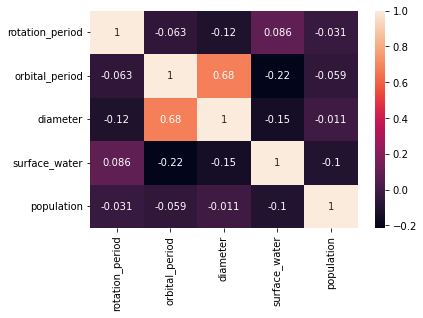

In [28]:
corr_planet=planets_df[planet_numeric_cols].corr()

sns.heatmap(corr_planet,annot=True)
plt.show()

In [29]:
planets_df['climate'].nunique()

20

<AxesSubplot: xlabel='climate', ylabel='count'>

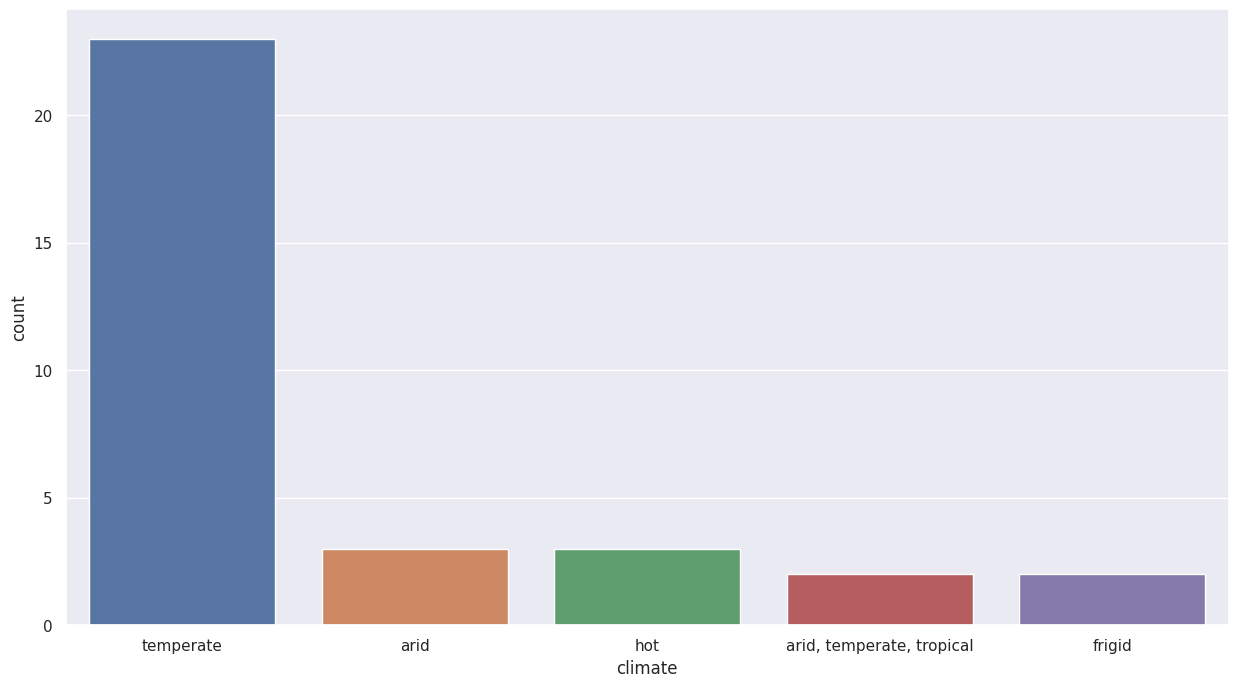

In [134]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(x=planets_df['climate'],order=planets_df.climate.value_counts().iloc[:5].index)

Films

In [30]:
films = get_full_type_data('http://swapi.dev/api/films/')
print("Number of films",films.shape[0])

Number of films 6


In [142]:
films.to_csv("films.csv",index=False)# Save data, so do not need to fetch data a second time

In [139]:
#Next time, just run this
films = pd.read_csv("films.csv")

In [31]:
films.head(3)

,title,episode_id,opening_crawl,director,producer,release_date,characters,planets,starships,vehicles,species,created,edited,url
0,A New Hope,4,It is a period of civil war.\r\nRebel spaceshi...,George Lucas,"Gary Kurtz, Rick McCallum",1977-05-25,"[https://swapi.dev/api/people/1/, https://swap...","[https://swapi.dev/api/planets/1/, https://swa...","[https://swapi.dev/api/starships/2/, https://s...","[https://swapi.dev/api/vehicles/4/, https://sw...","[https://swapi.dev/api/species/1/, https://swa...",2014-12-10T14:23:31.880000Z,2014-12-20T19:49:45.256000Z,https://swapi.dev/api/films/1/
1,The Empire Strikes Back,5,It is a dark time for the\r\nRebellion. Althou...,Irvin Kershner,"Gary Kurtz, Rick McCallum",1980-05-17,"[https://swapi.dev/api/people/1/, https://swap...","[https://swapi.dev/api/planets/4/, https://swa...","[https://swapi.dev/api/starships/3/, https://s...","[https://swapi.dev/api/vehicles/8/, https://sw...","[https://swapi.dev/api/species/1/, https://swa...",2014-12-12T11:26:24.656000Z,2014-12-15T13:07:53.386000Z,https://swapi.dev/api/films/2/
2,Return of the Jedi,6,Luke Skywalker has returned to\r\nhis home pla...,Richard Marquand,"Howard G. Kazanjian, George Lucas, Rick McCallum",1983-05-25,"[https://swapi.dev/api/people/1/, https://swap...","[https://swapi.dev/api/planets/1/, https://swa...","[https://swapi.dev/api/starships/2/, https://s...","[https://swapi.dev/api/vehicles/8/, https://sw...","[https://swapi.dev/api/species/1/, https://swa...",2014-12-18T10:39:33.255000Z,2014-12-20T09:48:37.462000Z,https://swapi.dev/api/films/3/


In [32]:
films=films.drop(columns=['created','edited','url'])
films['count_characters']=films['characters'].apply(lambda x: len(x))
films['count_planets']=films['planets'].apply(lambda x: len(x))
films['count_starships']=films['starships'].apply(lambda x: len(x))
films['count_vehicles']=films['vehicles'].apply(lambda x: len(x))
films['count_species']=films['species'].apply(lambda x: len(x))
films

,title,episode_id,opening_crawl,director,producer,release_date,characters,planets,starships,vehicles,species,count_characters,count_planets,count_starships,count_vehicles,count_species
0,A New Hope,4,It is a period of civil war.\r\nRebel spaceshi...,George Lucas,"Gary Kurtz, Rick McCallum",1977-05-25,"[https://swapi.dev/api/people/1/, https://swap...","[https://swapi.dev/api/planets/1/, https://swa...","[https://swapi.dev/api/starships/2/, https://s...","[https://swapi.dev/api/vehicles/4/, https://sw...","[https://swapi.dev/api/species/1/, https://swa...",18,3,8,4,5
1,The Empire Strikes Back,5,It is a dark time for the\r\nRebellion. Althou...,Irvin Kershner,"Gary Kurtz, Rick McCallum",1980-05-17,"[https://swapi.dev/api/people/1/, https://swap...","[https://swapi.dev/api/planets/4/, https://swa...","[https://swapi.dev/api/starships/3/, https://s...","[https://swapi.dev/api/vehicles/8/, https://sw...","[https://swapi.dev/api/species/1/, https://swa...",16,4,9,6,5
2,Return of the Jedi,6,Luke Skywalker has returned to\r\nhis home pla...,Richard Marquand,"Howard G. Kazanjian, George Lucas, Rick McCallum",1983-05-25,"[https://swapi.dev/api/people/1/, https://swap...","[https://swapi.dev/api/planets/1/, https://swa...","[https://swapi.dev/api/starships/2/, https://s...","[https://swapi.dev/api/vehicles/8/, https://sw...","[https://swapi.dev/api/species/1/, https://swa...",20,5,12,8,9
3,The Phantom Menace,1,Turmoil has engulfed the\r\nGalactic Republic....,George Lucas,Rick McCallum,1999-05-19,"[https://swapi.dev/api/people/2/, https://swap...","[https://swapi.dev/api/planets/1/, https://swa...","[https://swapi.dev/api/starships/31/, https://...","[https://swapi.dev/api/vehicles/33/, https://s...","[https://swapi.dev/api/species/1/, https://swa...",34,3,5,7,20
4,Attack of the Clones,2,There is unrest in the Galactic\r\nSenate. Sev...,George Lucas,Rick McCallum,2002-05-16,"[https://swapi.dev/api/people/2/, https://swap...","[https://swapi.dev/api/planets/1/, https://swa...","[https://swapi.dev/api/starships/21/, https://...","[https://swapi.dev/api/vehicles/4/, https://sw...","[https://swapi.dev/api/species/1/, https://swa...",40,5,9,11,14
5,Revenge of the Sith,3,War! The Republic is crumbling\r\nunder attack...,George Lucas,Rick McCallum,2005-05-19,"[https://swapi.dev/api/people/1/, https://swap...","[https://swapi.dev/api/planets/1/, https://swa...","[https://swapi.dev/api/starships/2/, https://s...","[https://swapi.dev/api/vehicles/33/, https://s...","[https://swapi.dev/api/species/1/, https://swa...",34,13,12,13,20


Speicies

In [33]:
species_df = get_full_type_data('http://swapi.dev/api/species/')
print("Number of films",species_df.shape[0])

Number of films 37


In [34]:
species_df.to_csv("species.csv",index=False)

In [35]:
#Next time, just run this
# species_df = pd.read_csv("species.csv")

#Not useful columns

species_df=species_df.drop(columns=['created','edited','url'])

In [36]:
species_df.head()

,name,classification,designation,average_height,skin_colors,hair_colors,eye_colors,average_lifespan,homeworld,language,people,films
0,Human,mammal,sentient,180,"caucasian, black, asian, hispanic","blonde, brown, black, red","brown, blue, green, hazel, grey, amber",120,https://swapi.dev/api/planets/9/,Galactic Basic,"[https://swapi.dev/api/people/66/, https://swa...","[https://swapi.dev/api/films/1/, https://swapi..."
1,Droid,artificial,sentient,n/a,n/a,n/a,n/a,indefinite,None,n/a,"[https://swapi.dev/api/people/2/, https://swap...","[https://swapi.dev/api/films/1/, https://swapi..."
2,Wookie,mammal,sentient,210,gray,"black, brown","blue, green, yellow, brown, golden, red",400,https://swapi.dev/api/planets/14/,Shyriiwook,"[https://swapi.dev/api/people/13/, https://swa...","[https://swapi.dev/api/films/1/, https://swapi..."
3,Rodian,sentient,reptilian,170,"green, blue",n/a,black,unknown,https://swapi.dev/api/planets/23/,Galatic Basic,[https://swapi.dev/api/people/15/],[https://swapi.dev/api/films/1/]
4,Hutt,gastropod,sentient,300,"green, brown, tan",n/a,"yellow, red",1000,https://swapi.dev/api/planets/24/,Huttese,[https://swapi.dev/api/people/16/],"[https://swapi.dev/api/films/1/, https://swapi..."


In [37]:
species_df=species_df.replace('unknown',np.NaN)

<AxesSubplot:>

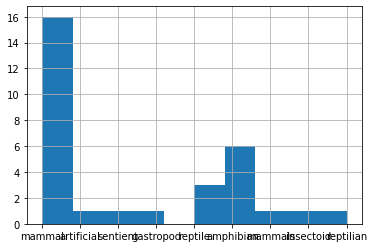

In [38]:
species_df['classification'].hist()

Obviously species that presented here, mammal are overrepresented with 16 appartion followed by amphibian

## Vehicles

In [39]:
# Scraping all vehi
vehicles_df = get_full_type_data('http://swapi.dev/api/vehicles/')
print("Number of vehicles",vehicles_df.shape[0])

Number of vehicles 39


In [40]:
vehicles_df.to_csv("vehicles.csv",index=False)# Save data, so do not need to fetch data a second time

In [158]:
#Next time, just run this
# vehicles_df = pd.read_csv("vehicles.csv")

## Starships

In [41]:
# Scraping all attributes of starships 

starships_df = get_full_type_data('http://swapi.dev/api/starships/')

print("Number of starships",starships_df.shape[0])

Number of starships 36


In [189]:
#Exporting of data to csv format

starships_df.to_csv('starships.csv',index=False)

In [42]:
#Reading of data from a saved csv file

# starships_df=pd.read_csv('starships.csv')

# Drop not useful columns from our data

starships_df=starships_df.drop(columns=['created','edited','url'])

In [43]:
starships_df.head(2)

,name,model,manufacturer,cost_in_credits,length,max_atmosphering_speed,crew,passengers,cargo_capacity,consumables,hyperdrive_rating,MGLT,starship_class,pilots,films
0,CR90 corvette,CR90 corvette,Corellian Engineering Corporation,3500000,150,950,30-165,600,3000000,1 year,2.0,60,corvette,[],"[https://swapi.dev/api/films/1/, https://swapi..."
1,Star Destroyer,Imperial I-class Star Destroyer,Kuat Drive Yards,150000000,"1,600",975,"47,060",n/a,36000000,2 years,2.0,60,Star Destroyer,[],"[https://swapi.dev/api/films/1/, https://swapi..."


In [220]:
starships_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   name                    36 non-null     object
 1   model                   36 non-null     object
 2   manufacturer            36 non-null     object
 3   cost_in_credits         26 non-null     object
 4   length                  36 non-null     object
 5   max_atmosphering_speed  29 non-null     object
 6   crew                    35 non-null     object
 7   passengers              32 non-null     object
 8   cargo_capacity          29 non-null     object
 9   consumables             31 non-null     object
 10  hyperdrive_rating       35 non-null     object
 11  MGLT                    17 non-null     object
 12  starship_class          36 non-null     object
 13  pilots                  36 non-null     object
 14  films                   36 non-null     object
dtypes: objec

In [50]:
# Replacing 'unknown' by NaN to facilitate interaction and conversion of our dataframe and also NaN is
# handled in most of python functions

starships_df=starships_df.replace('unknown',np.NaN).replace('n/a',np.NaN)

# Familiarising with size of NaN per columns of data

missing_values_table(starships_df)

Your selected stage_dataframe has 15 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
consumables,5,13.9
max_atmosphering_speed,4,11.1
passengers,1,2.8


In [51]:
num_cols=['cost_in_credits','length','max_atmosphering_speed','crew','cargo_capacity','passengers','hyperdrive_rating','MGLT']
for col in num_cols:
    # For all columns in numeric vars list we featured them to right structure
     #-I find that separator is "," inplace of "."
     #- '-' between numbers that is supposed to unique number
     #- 'km' in number, need to fix that to allow conversion
    
    starships_df[col]=starships_df[col].apply(lambda x: str(x).replace(',','.'))
    starships_df[col]=starships_df[col].apply(lambda x: str(x).replace('-',''))
    starships_df[col]=starships_df[col].apply(lambda x: str(x).replace('km',' '))

In [52]:
# Converting all numerics columns in right data type for displaying some statistics

starships_df[num_cols]=starships_df[num_cols].astype('float')

starships_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   name                    36 non-null     object 
 1   model                   36 non-null     object 
 2   manufacturer            36 non-null     object 
 3   cost_in_credits         26 non-null     float64
 4   length                  36 non-null     float64
 5   max_atmosphering_speed  29 non-null     float64
 6   crew                    35 non-null     float64
 7   passengers              32 non-null     float64
 8   cargo_capacity          29 non-null     float64
 9   consumables             31 non-null     object 
 10  hyperdrive_rating       35 non-null     float64
 11  MGLT                    17 non-null     float64
 12  starship_class          36 non-null     object 
 13  pilots                  36 non-null     object 
 14  films                   36 non-null     obje

In [53]:
#This functions give a quick statistics descriptive values 

starships_df.describe()

,cost_in_credits,length,max_atmosphering_speed,crew,passengers,cargo_capacity,hyperdrive_rating,MGLT
count,2.600000e+01,36.000000,29.000000,35.000000,32.000000,2.900000e+01,35.000000,17.000000
mean,3.852734e+10,4130.570833,1356.896552,1321.061629,8632.010688,3.463580e+10,1.585714,67.705882
std,1.961028e+11,20115.591586,1313.952199,5242.959287,26561.513124,1.856674e+11,1.139438,30.209197
min,3.570000e+04,1.600000,650.000000,1.000000,0.000000,4.000000e+01,0.500000,10.000000
25%,1.697500e+05,13.625000,975.000000,1.000000,0.000000,1.100000e+02,1.000000,50.000000
50%,2.800000e+05,31.785000,1050.000000,5.000000,10.500000,8.000000e+04,1.000000,70.000000
75%,5.650000e+07,322.500000,1180.000000,187.500000,660.835500,1.900000e+07,2.000000,91.000000
max,1.000000e+12,120000.000000,8000.000000,30165.000000,139000.000000,1.000000e+12,6.000000,120.000000


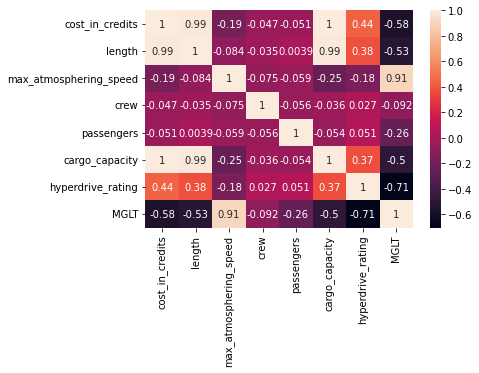

In [54]:
corr_star=starships_df.corr()


sns.heatmap(corr_star,annot=True)

plt.show()

By reading this table, we can find that some variables have strong relationship and other no. For postive relationship:
    
    - length, cost in credits and cargo capcity are strongly positive correlated.
    - max_atmosphere_speed and MGLT are more correlated also by 0.91
    - But more MGLT grow up hyperdrive_ratio decrease
    - ...

Here let's try something that needs information from more than 1 datasets

Let's try to see if height is related to the planet's gravity. This would requires data from both planets and people datasets.

In [55]:
people.head(3)

,name,height,mass,hair_color,skin_color,eye_color,birth_year,gender,homeworld,films,...,vehicles,starships,created,edited,url,film_num,vehicles_num,starships_num,bmi,health
0,Luke Skywalker,172.0,77.0,blond,fair,blue,19BBY,male,https://swapi.dev/api/planets/1/,"[https://swapi.dev/api/films/1/, https://swapi...",...,"[https://swapi.dev/api/vehicles/14/, https://s...","[https://swapi.dev/api/starships/12/, https://...",2014-12-09T13:50:51.644000Z,2014-12-20T21:17:56.891000Z,https://swapi.dev/api/people/1/,4,2,2,26.027582,too_fat
1,C-3PO,167.0,75.0,n/a,gold,yellow,112BBY,n/a,https://swapi.dev/api/planets/1/,"[https://swapi.dev/api/films/1/, https://swapi...",...,[],[],2014-12-10T15:10:51.357000Z,2014-12-20T21:17:50.309000Z,https://swapi.dev/api/people/2/,6,0,0,26.892323,too_fat
2,R2-D2,96.0,32.0,n/a,"white, blue",red,33BBY,n/a,https://swapi.dev/api/planets/8/,"[https://swapi.dev/api/films/1/, https://swapi...",...,[],[],2014-12-10T15:11:50.376000Z,2014-12-20T21:17:50.311000Z,https://swapi.dev/api/people/3/,6,0,0,34.722222,too_fat


In [61]:
# Get numerical gravity
def remove_none(x):
    x=str(x)
    x=x.lower()
    if x in ['n/a','none','unknown']:
        return False
    else:
        return True
planets_with_gravity = planets_df[planets_df['gravity'].apply(lambda x: remove_none(x))]
def get_gravity_num(x):
    x=str(x)
    if x[-8:]=='standard':
        gravity_num = float(x[:-8])
    elif x =='1.5 (surface), 1 standard (Cloud City)':
        gravity_num = 1.5
    else:
        gravity_num = float(x)
    return gravity_num

planets_with_gravity['gravity_num'] = planets_with_gravity['gravity'].apply(lambda x: get_gravity_num(x))

planets_with_gravity.head(3)



C:\Users\Qing\AppData\Local\Temp\ipykernel_536\1010391803.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  planets_with_gravity['gravity_num'] = planets_with_gravity['gravity'].apply(lambda x: get_gravity_num(x))


,name,rotation_period,orbital_period,diameter,climate,gravity,terrain,surface_water,population,residents,films,created,edited,url,gravity_num
0,Tatooine,23.0,304.0,10465.0,arid,1 standard,desert,1.0,2.000000e+05,"[https://swapi.dev/api/people/1/, https://swap...","[https://swapi.dev/api/films/1/, https://swapi...",2014-12-09T13:50:49.641000Z,2014-12-20T20:58:18.411000Z,https://swapi.dev/api/planets/1/,1.0
1,Alderaan,24.0,364.0,12500.0,temperate,1 standard,"grasslands, mountains",40.0,2.000000e+09,"[https://swapi.dev/api/people/5/, https://swap...","[https://swapi.dev/api/films/1/, https://swapi...",2014-12-10T11:35:48.479000Z,2014-12-20T20:58:18.420000Z,https://swapi.dev/api/planets/2/,1.0
2,Yavin IV,24.0,4818.0,10200.0,"temperate, tropical",1 standard,"jungle, rainforests",8.0,1.000000e+03,[],[https://swapi.dev/api/films/1/],2014-12-10T11:37:19.144000Z,2014-12-20T20:58:18.421000Z,https://swapi.dev/api/planets/3/,1.0


In [62]:
gravity_map = dict(zip(planets_with_gravity.url, planets_with_gravity.gravity_num))
gravity_map

{'https://swapi.dev/api/planets/1/': 1.0,
 'https://swapi.dev/api/planets/2/': 1.0,
 'https://swapi.dev/api/planets/3/': 1.0,
 'https://swapi.dev/api/planets/4/': 1.1,
 'https://swapi.dev/api/planets/6/': 1.5,
 'https://swapi.dev/api/planets/7/': 0.85,
 'https://swapi.dev/api/planets/8/': 1.0,
 'https://swapi.dev/api/planets/9/': 1.0,
 'https://swapi.dev/api/planets/10/': 1.0,
 'https://swapi.dev/api/planets/11/': 0.9,
 'https://swapi.dev/api/planets/12/': 1.0,
 'https://swapi.dev/api/planets/13/': 1.0,
 'https://swapi.dev/api/planets/14/': 1.0,
 'https://swapi.dev/api/planets/15/': 0.56,
 'https://swapi.dev/api/planets/16/': 1.0,
 'https://swapi.dev/api/planets/17/': 0.75,
 'https://swapi.dev/api/planets/18/': 1.0,
 'https://swapi.dev/api/planets/19/': nan,
 'https://swapi.dev/api/planets/20/': 1.0,
 'https://swapi.dev/api/planets/21/': 1.0,
 'https://swapi.dev/api/planets/22/': 1.0,
 'https://swapi.dev/api/planets/23/': 1.0,
 'https://swapi.dev/api/planets/24/': 1.0,
 'https://swapi.

In [63]:
people['gravity_num'] = people['homeworld'].map(gravity_map,na_action='ignore')
people.head(3)

,name,height,mass,hair_color,skin_color,eye_color,birth_year,gender,homeworld,films,...,starships,created,edited,url,film_num,vehicles_num,starships_num,bmi,health,gravity_num
0,Luke Skywalker,172.0,77.0,blond,fair,blue,19BBY,male,https://swapi.dev/api/planets/1/,"[https://swapi.dev/api/films/1/, https://swapi...",...,"[https://swapi.dev/api/starships/12/, https://...",2014-12-09T13:50:51.644000Z,2014-12-20T21:17:56.891000Z,https://swapi.dev/api/people/1/,4,2,2,26.027582,too_fat,1.0
1,C-3PO,167.0,75.0,n/a,gold,yellow,112BBY,n/a,https://swapi.dev/api/planets/1/,"[https://swapi.dev/api/films/1/, https://swapi...",...,[],2014-12-10T15:10:51.357000Z,2014-12-20T21:17:50.309000Z,https://swapi.dev/api/people/2/,6,0,0,26.892323,too_fat,1.0
2,R2-D2,96.0,32.0,n/a,"white, blue",red,33BBY,n/a,https://swapi.dev/api/planets/8/,"[https://swapi.dev/api/films/1/, https://swapi...",...,[],2014-12-10T15:11:50.376000Z,2014-12-20T21:17:50.311000Z,https://swapi.dev/api/people/3/,6,0,0,34.722222,too_fat,1.0


In [64]:
people[['height','gravity_num']].corr()

,height,gravity_num
height,1.000000,-0.144998
gravity_num,-0.144998,1.000000


The correlation verifies our hypothesis. Lower gravity, the taller the people 